# Classifying Events with:
* Logistic Regression
* Random Forests
* SVM
* Naive Bayes



In [23]:
#Use mne XDawn for preprocessing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import mne
from mne import io, pick_types, read_events, Epochs
# from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer, Scaler
from mne.viz import tight_layout

import os
import os.path as op

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

#data path for each run of each subject.
# drive_data_path = 'E:\eeg_data'

#data path on my external hdd for folder containing all tests of each subject in one file
# drive_all_data_path = 'E:\eeg_data\ica_140_500_0.1'

#local path
path = 'C:\Users\Esimk\OneDrive\Desktop\eeg_data'

In [2]:
# import all runs data from 10 subjects

#initalize a np array of numbers from 1 to 5. This is the number of subjects
np.random.seed(41)
numb_subj = np.random.randint(1,25,5)
numb_subj
print("subject number used for classification:",numb_subj)
#empty array that will have all file names
files = []

for i in range(len(numb_subj)):
    files.append(str('subject' + str(numb_subj[i]) + '_all_runs-epo.fif'))

#convert to np array
files = np.array(files)

all_data = []
for i in range(len(files)):
     all_data.append(mne.read_epochs(op.join(path, files[i]),
                          preload=True));

('subject number used for classification:', array([ 1,  4, 13,  3, 17]))
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\ica_140_500_0.1\subject1_all_runs-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\ica_140_500_0.1\subject4_all_runs-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
615 matching events found
Created an SSP operator (subspace dimension = 1)
615 matching events found
Created a

In [3]:
#extract event_id 4 and 5 from all data

all_epochs = []
for i in range(len(all_data)):
    all_epochs.append(all_data[i][(all_data[i].events[:,-1] == 4) | (all_data[i].events[:,-1] == 5)])

In [4]:
#concatenate epochs list
epochs = mne.concatenate_epochs(all_epochs)

2186 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


In [5]:
epochs = epochs.pick_channels(epochs.ch_names[:60])

In [6]:
clf = make_pipeline(Xdawn(n_components = 3),
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1'))
#cross validator
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)


#Do cross-validation
labels = epochs.events[:,-1]
preds = np.empty(len(labels))

for train, test in cv.split(epochs, labels):
    clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])
    
target_names = ['new', 'scramble']
report = classification_report(labels, preds, target_names=target_names)
print(report)

             precision    recall  f1-score   support

        new       0.63      0.67      0.65      1195
   scramble       0.57      0.52      0.54       991

avg / total       0.60      0.60      0.60      2186



In [7]:
# Normalized confusion matrix
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

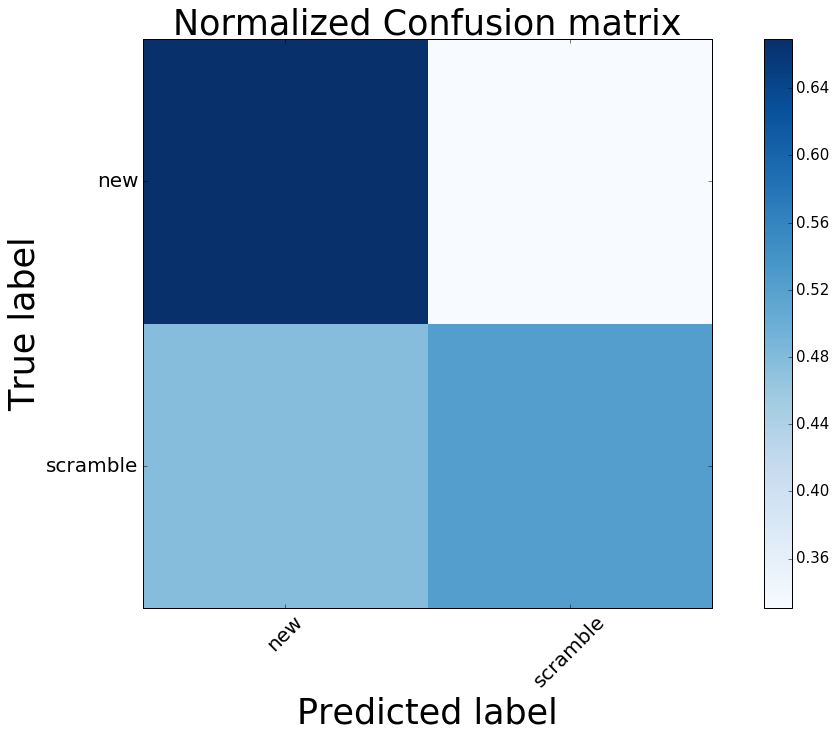

In [10]:
# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix', fontsize = 35)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, fontsize = 20)
plt.yticks(tick_marks, target_names, fontsize = 20)
tight_layout()
plt.ylabel('True label', fontsize = 35)
plt.xlabel('Predicted label',fontsize = 35)
plt.show()

In [ ]:
clf.score(epochs[test],labels[test])

## More tests by sampling more files

In [ ]:
np.random.seed(42)
subjects = []
#generate 10 random samples of 5 files 
for i in range(10):
    subjects.append(np.random.choice(25,5))
subjects = np.array(subjects)
print(subjects)

In [3]:
#read file
def read_file(path, file_name):
    return mne.read_epochs(op.join(path, file_name),
                          preload=True);

In [4]:
def filter_new_scrambled(epochs):
    """Filter events in epoch data
    epochs: mne.epochs.EpochsFIF object 
    """
    
    return epochs[(epochs.events[:,-1] == 4) | (epochs.events[:,-1] == 5)] 

In [5]:
epochs = read_file(drive_all_data_path,'subject1_all_runs-epo.fif');

Reading E:\eeg_data\ica_140_500_0.1\subject1_all_runs-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [6]:
epochs = filter_new_scrambled(epochs)
#Having 61 channels does not work when classifiying for some reason. It seems like any number less than 61 works. 
epochs = epochs.pick_channels(epochs.ch_names[:60])

## Trying to classify one *all runs* file
* using 60 channels

In [7]:
clf = make_pipeline(Xdawn(n_components = 3),
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l2'))
#cross validator
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)


#Do cross-validation
labels = epochs.events[:,-1]
preds = np.empty(len(labels))

for train, test in cv.split(epochs, labels):
    clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])
    
target_names = ['new', 'scramble']
report = classification_report(labels, preds, target_names=target_names)
print(report)

             precision    recall  f1-score   support

        new       0.67      0.70      0.69       293
   scramble       0.65      0.62      0.64       264

avg / total       0.66      0.66      0.66       557



In [8]:
clf.score(epochs[test],labels[test])

0.67272727272727273

# Trying to classify the same file but with one channel
* How will classification perform if only one channel is used?
* I will choose one random channel.

In [9]:
np.random.seed(42)
chan_numb = np.random.choice(60)

In [10]:
chan_numb

38

In [11]:
#extract one channel
epochs.pick_channels(epochs.ch_names[chan_numb:chan_numb+1])

<EpochsFIF  |  n_events : 557 (all good), tmin : 0.0 (s), tmax : 1.4 (s), baseline : (0.0, 1.399999976158142), ~6.0 MB, data loaded,
 u'new': 293, u'scramble': 264>

# Observations of the plots
* Looking at 200ms sections of each plot and trying to see if there are clear differences between the events.
* at 600 - 800ms, all but the bottom left have a high differences. 

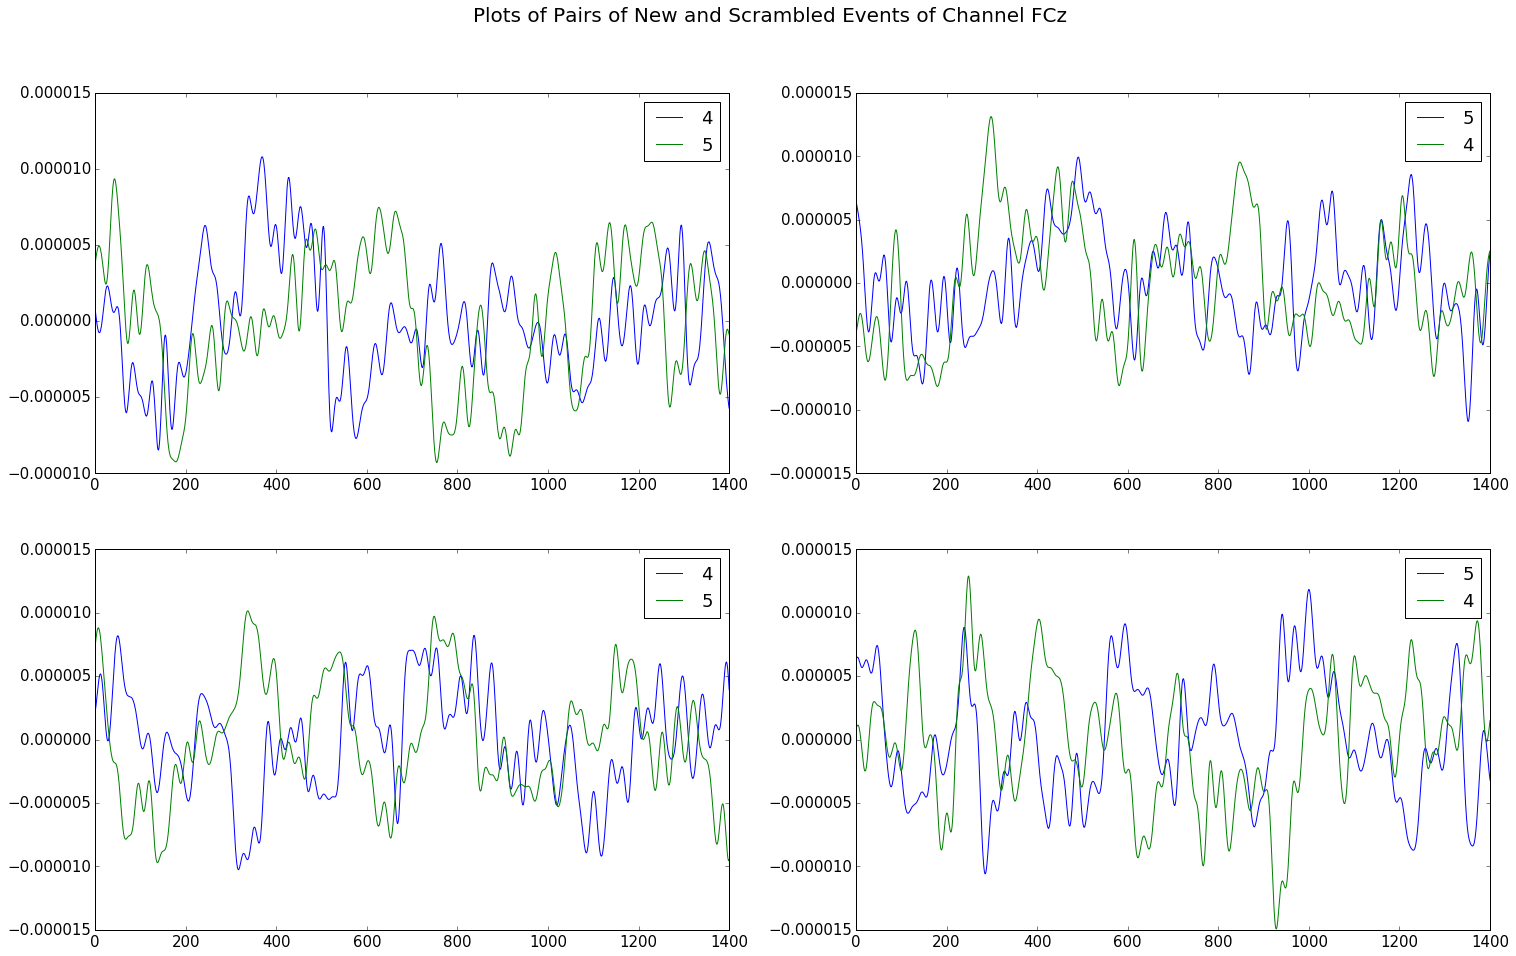

In [12]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (25,15), )

fig.suptitle("Plots of Pairs of New and Scrambled Events of Channel {}".format(epochs.ch_names[-1]), fontsize=20);

axs[0,0].plot(epochs._data[0][0], label = epochs.events[0][-1])
axs[0,0].plot(epochs._data[1][0], label = epochs.events[1][-1])

axs[0,1].plot(epochs._data[3][0], label = epochs.events[3][-1])
axs[0,1].plot(epochs._data[4][0], label = epochs.events[4][-1])              

axs[1,0].plot(epochs._data[5][0], label = epochs.events[5][-1])
axs[1,0].plot(epochs._data[6][0], label = epochs.events[6][-1])              

axs[1,1].plot(epochs._data[8][0], label = epochs.events[8][-1])
axs[1,1].plot(epochs._data[9][0], label = epochs.events[9][-1])              

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend();

## Convert the epoched data of one channel into a pandas dataframe

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [14]:
#initialize np array of shape epoch length and time of 1400 ms.
np_epochs = np.empty(shape = (len(epochs),1401))

In [15]:
epochs[0]._data

array([[[  9.00176705e-07,   5.91821144e-07,   3.10939599e-07, ...,
          -5.28031655e-06,  -5.52596433e-06,  -5.73424470e-06]]])

In [16]:
# assign values of each epoch to np array
for i in range(len(epochs)):
    np_epochs[i] = epochs[i]._data
    
# pd.DataFrame(epochs._data.reshape(-1,1))

In [17]:
# create pandas df
epoch_df = pd.DataFrame(np_epochs)
# add event column
epoch_df['event'] = epochs.events[:,-1]

In [18]:
# a column for each millisecond
epoch_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1392,1393,1394,1395,1396,1397,1398,1399,1400,event
0,9.001767e-07,5.918211e-07,3.109396e-07,6.029932e-08,-1.604241e-07,-3.539904e-07,-5.128190e-07,-6.334406e-07,-7.133931e-07,-7.600088e-07,...,-3.119980e-06,-3.556240e-06,-3.959968e-06,-4.336436e-06,-4.684804e-06,-5.001530e-06,-5.280317e-06,-5.525964e-06,-5.734245e-06,4
1,3.673802e-06,3.941456e-06,4.168054e-06,4.360412e-06,4.547438e-06,4.688513e-06,4.805973e-06,4.882078e-06,4.922092e-06,4.926733e-06,...,-1.081558e-06,-8.615998e-07,-6.845507e-07,-5.789630e-07,-5.279091e-07,-5.580111e-07,-6.476509e-07,-7.559973e-07,-8.939475e-07,5
2,-5.028482e-06,-5.201513e-06,-5.375548e-06,-5.542635e-06,-5.719817e-06,-5.888659e-06,-6.073559e-06,-6.259675e-06,-6.446023e-06,-6.627049e-06,...,-1.104892e-06,-1.002244e-06,-8.631719e-07,-6.858122e-07,-4.771425e-07,-2.381743e-07,3.296271e-08,3.219094e-07,6.322077e-07,5
3,6.467264e-06,6.296004e-06,6.103625e-06,5.900337e-06,5.689889e-06,5.461426e-06,5.229706e-06,4.992553e-06,4.745827e-06,4.475589e-06,...,-1.737644e-06,-1.078531e-06,-4.223567e-07,2.043566e-07,7.986549e-07,1.334446e-06,1.789113e-06,2.162092e-06,2.447947e-06,5
4,-4.032329e-06,-3.822209e-06,-3.597012e-06,-3.364319e-06,-3.136019e-06,-2.927727e-06,-2.734367e-06,-2.581594e-06,-2.465835e-06,-2.401535e-06,...,5.451195e-07,9.637967e-07,1.344826e-06,1.667548e-06,1.932357e-06,2.151599e-06,2.324925e-06,2.449798e-06,2.540480e-06,4


In [19]:
# X values are the 1400 columns
X = epoch_df.iloc[:,:-1].values
# y values are events
y = epoch_df.iloc[:,-1:].values
#split data into training/ test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .30, random_state = 42)

In [20]:
#initialize classifier
clf = LogisticRegression(penalty='l1')
#fit data
clf.fit(X_train,y_train)

C:\Users\Esimk_000\Anaconda3\envs\py27\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

* This did not yield good results. 
* Why?

In [21]:
#score..is not good
clf.score(X_test,y_test)

0.48809523809523808

# MNE Python offers decoding for maximal compatability with scikit-learn
* Two key steps for decoding
    1. Estimator
    2. Spatial Filter

## Try scaling EEG data using mne.decoding.Scaler

In [39]:
#read data
epochs = read_file(drive_all_data_path,'subject1_all_runs-epo.fif')

Reading E:\eeg_data\ica_140_500_0.1\subject1_all_runs-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [42]:
scaler = mne.decoding.Scaler()
scaler

Scaler(info=None, scalings=None, with_mean=True, with_std=True)

In [60]:
epochs = epochs.pick_channels(epochs.ch_names[:60])

In [65]:
clf = make_pipeline( Xdawn(n_components = 3),
                    Vectorizer())
labels = epochs.events[:,-1]

In [66]:

clf.fit(epochs, labels)

Pipeline(memory=None,
     steps=[('xdawn', Xdawn(correct_overlap='auto', n_components=3, reg=None, signal_cov=None)), ('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x000000001229CBE0>)])

In [76]:
epoch_transformed = clf.transform(epochs)

In [87]:
print(epochs._data.shape)
#why are the dimensions the way they are?
print(epoch_transformed.shape)

(1121L, 60L, 1401L)
(1121L, 16812L)


# Function for classifying

In [37]:
def classify(epochs, scaler, classifier, tts = True, cv = False):
    #identify scaler
    if scaler == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler == 'MinMaxScaler':
        scaler = MinMaxScaler()
    
    #identify classifier
    if classifier == 'LogisticRegression':
        classifier = LogisticRegression()
    elif classifier == 'RandomForests':
        classifier = RandomForestClassifier()
    elif classifier == 'LDA':
        classifier = LinearDiscriminantAnalysis()
    
    clf = make_pipeline(scaler,
                        classifier)
    X = epochs.get_data()
    y = epochs.events[:,-1]
    #cross valiation
    if tts == True:
        print('in tts')
        X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                            test_size = 0.3,
                                                            random_state = 42)
        
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        
        
    if cv == True:
        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
        labels = y
        epochs = X
        preds = np.empty(len(labels))
        for train, test in cv.split(epochs, labels):
            clf.fit(epochs[train], labels[train])
            preds[test] = clf.predict(epochs[test])
            
            score = clf.score(epochs[test], labels[test])
    
    return score
    

In [19]:
epochs = mne.read_epochs(op.join(path, 'Ex10_Suj1_Run1-epo.fif'),
                          preload=True);

epochs = epochs[(epochs.events[:,-1] == 4) | (epochs.events[:,-1] == 5)]

Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [38]:

classify(epochs, scaler = 'StandardScaler', classifier='LogisticRegression',
        tts = True, cv = False)

in tts


ValueError: Found array with dim 3. StandardScaler expected <= 2.

In [34]:
X = epochs.get_data()
y = epochs.events[:,-1]
  
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3,
                                                    random_state = 42)